In [1]:
import os
import time
import h5py
import glob
import time
import numpy as np
import xarray as xr

import pandas as pd
import geopandas as gpd

from datetime import datetime

from shapely.geometry import Point

import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import weibull_min
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import curve_fit, minimize, fsolve
from scipy.optimize import differential_evolution

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import patches
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

from pathos.multiprocessing import ProcessingPool as Pool

from playsound import playsound

import sys
sys.path.insert(0, os.path.abspath("../function"))
from ART_preprocessing import ART_downscalling

import warnings
warnings.filterwarnings('ignore')

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson')

if os.path.exists(veneto_dir):
    Veneto = gpd.read_file(veneto_dir)
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [3]:
OBS_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Weibull','VENETO_WEIBULL_OBS_IMERG_025x025_1981_2023.nc')
OBS = xr.open_dataset(OBS_dir)

lon_2d_OBS, lat_2d_OBS = np.meshgrid(OBS['lon'], OBS['lat'])

In [4]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')
data_dir = os.path.join(dir_base,'IMERG','3_hour',f'IMERG_Veneto_3h_2001_01_01_2023_12_31_025x025.nc')

if os.path.exists(data_dir):
    DATA = xr.open_dataset(data_dir)
    # DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))
else:
    raise SystemExit(f"File not found: {data_dir}")

# The first row and last column are NaN maybe were be created in the CDO agregations 
lat_min, lat_max, lon_min, lon_max = 44, 47, 10, 14
DATA = DATA.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

lats = DATA['lat'].data
lons = DATA['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

year_vector = np.unique(pd.to_datetime(DATA['time']).year)

DATES = DATA['time'][:]

DATA

<xarray.Dataset> Size: 104MB
Dimensions:  (time: 67200, lon: 16, lat: 12)
Coordinates:
  * time     (time) datetime64[ns] 538kB 2001-01-01 ... 2023-12-31T21:00:00
  * lon      (lon) float32 64B 10.12 10.38 10.62 10.88 ... 13.38 13.62 13.88
  * lat      (lat) float32 48B 44.12 44.38 44.62 44.88 ... 46.38 46.62 46.88
Data variables:
    PRE      (time, lat, lon) float64 103MB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    description:  IMERG 3 hour data for Veneto region
    history:      Tue Nov 12 09:42:36 2024: cdo remapbil,TRMM_Veneto_3h_1998_...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [5]:
MASK = np.argwhere(~np.isnan(np.nanmean(OBS['Wetdays'].values,axis=0)))

binary_mask = np.zeros_like(OBS['Wetdays'].values[0, :, :], dtype=int)
for lat, lon in MASK:
    binary_mask[lat, lon] = 1

MEAN_ = np.nanmean(DATA['PRE'],axis=0)
masked_MEAN_ = np.where(binary_mask == 1, MEAN_, np.nan)

Text(0.0, 1.0, '(b) IMERG 025x025')

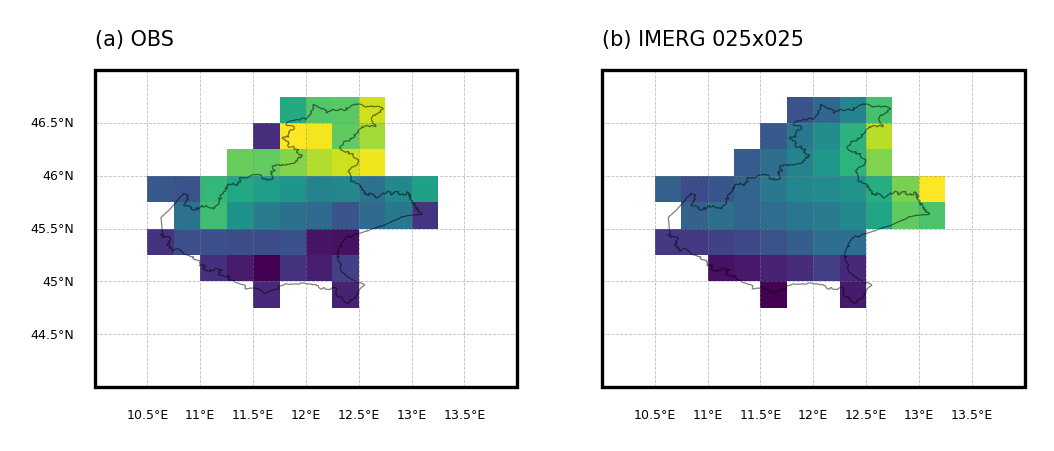

In [6]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
# ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon_2d_OBS, lat_2d_OBS, OBS['Wetdays'].mean(dim='time'))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.set_title('(a) OBS', loc='left', size=5)

# ================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
# ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, masked_MEAN_)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.set_title('(b) IMERG 025x025', loc='left', size=5)

In [7]:
parameters = dict({
    'L1':25,
    'origin_x': 25,
    'radio':0.3,
    'npix':3,
    'thresh': 1,

    'maxmiss':40,
    'condition': 'OVERLEAP',

    'L0':0,
    'tmax': 48,
    'dt': 3,

    'origin_t': 24,
    'target_x': 0,
    'target_t': 24,

    'ninterp':2000,

    'acf': 'mar',
    'corr_method':'pearson',
    'cores': 12,
})

In [8]:
IMERG_WD = np.zeros([len(year_vector),len(lats),len(lons)])*np.nan
IMERG_SC = np.zeros([len(year_vector),len(lats),len(lons)])*np.nan
IMERG_SH = np.zeros([len(year_vector),len(lats),len(lons)])*np.nan

DOWN_WD = np.zeros([len(year_vector),len(lats),len(lons)])*np.nan
DOWN_SC = np.zeros([len(year_vector),len(lats),len(lons)])*np.nan
DOWN_SH = np.zeros([len(year_vector),len(lats),len(lons)])*np.nan

M_beta = np.zeros([len(lats),len(lons)])*np.nan
M_gamma = np.zeros([len(lats),len(lons)])*np.nan

In [9]:
# XXX min para 170 puntos, 3.2 min por punto

start_time = time.time()

step = 1
for la, lo in MASK:
    print(f'PROCESING STEP {step} of {len(MASK)}')
    IMERG_WEIBULL_YY, DOWN_WEIBULL_YY, dict_out, = ART_downscalling(DATA, lats, lons, lats[la], lons[lo], parameters)
    IMERG_WD[:,la,lo] = IMERG_WEIBULL_YY[:,0]
    IMERG_SC[:,la,lo] = IMERG_WEIBULL_YY[:,1]
    IMERG_SH[:,la,lo] = IMERG_WEIBULL_YY[:,2]

    DOWN_WD[:,la,lo] = DOWN_WEIBULL_YY[:,0]
    DOWN_SC[:,la,lo] = DOWN_WEIBULL_YY[:,1]
    DOWN_SH[:,la,lo] = DOWN_WEIBULL_YY[:,2]

    M_beta[la,lo] = dict_out['beta']
    M_gamma[la,lo] = dict_out['gamma']
    
    step += 1
    print()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

PROCESING STEP 1 of 52
neihgborhood area: 3x3
differential_evolution step 1: f(x)= 0.0013164729059691976
Polishing solution with 'L-BFGS-B'
Gamma value: 0.9062004165859773

PROCESING STEP 2 of 52
neihgborhood area: 3x3
differential_evolution step 1: f(x)= 0.0026729691943749275
Polishing solution with 'L-BFGS-B'
Gamma value: 0.8708713411718404

PROCESING STEP 3 of 52
neihgborhood area: 3x3
differential_evolution step 1: f(x)= 0.002430503066588841
Polishing solution with 'L-BFGS-B'
Gamma value: 0.9080520722453304

PROCESING STEP 4 of 52
neihgborhood area: 3x3
differential_evolution step 1: f(x)= 0.0024712463053415245
Polishing solution with 'L-BFGS-B'
Gamma value: 0.9073435381879258

PROCESING STEP 5 of 52
neihgborhood area: 3x3
differential_evolution step 1: f(x)= 0.002272176794935515
differential_evolution step 2: f(x)= 0.002085486269229094
Polishing solution with 'L-BFGS-B'
Gamma value: 0.9017017710426412

PROCESING STEP 6 of 52
neihgborhood area: 3x3
differential_evolution step 1: f(

In [10]:
WEIBULL_xr = xr.Dataset(data_vars={
                "IMERG_WD": (("time","lat","lon"), IMERG_WD),
                "IMERG_SC": (("time","lat","lon"), IMERG_SC),
                "IMERG_SH": (("time","lat","lon"), IMERG_SH),
                "DOWN_WD": (("time","lat","lon"), DOWN_WD),
                "DOWN_SC": (("time","lat","lon"), DOWN_SC),
                "DOWN_SH": (("time","lat","lon"), DOWN_SH),
                "BETA":(("lat","lon"), M_beta),
                "GAMMA":(("lat","lon"), M_gamma)},
                    coords={'time': pd.to_datetime(year_vector, format='%Y'), 'lat': lats, 'lon': lons},
                    attrs=dict(description=f"Weibull parameters for Veneto using IMERG 025x025 data"))

WEIBULL_xr.IMERG_WD.attrs["units"] = "Number of days"
WEIBULL_xr.IMERG_WD.attrs["long_name"] = "IMERG wet days"

WEIBULL_xr.IMERG_SC.attrs["units"] = "dimensionless"
WEIBULL_xr.IMERG_SC.attrs["long_name"] = "IMERG Scale"

WEIBULL_xr.IMERG_SH.attrs["units"] = "dimensionless"
WEIBULL_xr.IMERG_SH.attrs["long_name"] = "IMERG Shape"

WEIBULL_xr.DOWN_WD.attrs["units"] = "Number of days"
WEIBULL_xr.DOWN_WD.attrs["long_name"] = "DOWN wet days"

WEIBULL_xr.DOWN_SC.attrs["units"] = "dimensionless"
WEIBULL_xr.DOWN_SC.attrs["long_name"] = "DOWN Scale"

WEIBULL_xr.DOWN_SH.attrs["units"] = "dimensionless"
WEIBULL_xr.DOWN_SH.attrs["long_name"] = "DOWN Shape"

WEIBULL_xr.BETA.attrs["units"] = "dimensionless"
WEIBULL_xr.BETA.attrs["long_name"] = "Beta parameter"

WEIBULL_xr.GAMMA.attrs["units"] = "dimensionless"
WEIBULL_xr.GAMMA.attrs["long_name"] = "Gamma parameter"

WEIBULL_xr.lat.attrs["units"] = "degrees_north"
WEIBULL_xr.lat.attrs["long_name"] = "Latitude"

WEIBULL_xr.lon.attrs["units"] = "degrees_east"
WEIBULL_xr.lon.attrs["long_name"] = "Longitude"

In [11]:
WEIBULL_xr

<xarray.Dataset> Size: 215kB
Dimensions:   (time: 23, lat: 12, lon: 16)
Coordinates:
  * time      (time) datetime64[ns] 184B 2001-01-01 2002-01-01 ... 2023-01-01
  * lat       (lat) float32 48B 44.12 44.38 44.62 44.88 ... 46.38 46.62 46.88
  * lon       (lon) float32 64B 10.12 10.38 10.62 10.88 ... 13.38 13.62 13.88
Data variables:
    IMERG_WD  (time, lat, lon) float64 35kB nan nan nan nan ... nan nan nan nan
    IMERG_SC  (time, lat, lon) float64 35kB nan nan nan nan ... nan nan nan nan
    IMERG_SH  (time, lat, lon) float64 35kB nan nan nan nan ... nan nan nan nan
    DOWN_WD   (time, lat, lon) float64 35kB nan nan nan nan ... nan nan nan nan
    DOWN_SC   (time, lat, lon) float64 35kB nan nan nan nan ... nan nan nan nan
    DOWN_SH   (time, lat, lon) float64 35kB nan nan nan nan ... nan nan nan nan
    BETA      (lat, lon) float64 2kB nan nan nan nan nan ... nan nan nan nan nan
    GAMMA     (lat, lon) float64 2kB nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    description:  Weibull parameters for Veneto using IMERG 025x025 data

In [12]:
WEIBULL_out = os.path.join('/','media','arturo','Arturo','Data','Italy','Weibull',f'VENETO_WEIBULL_IMERG_025x025_{year_vector[0]}_{year_vector[-1]}.nc')
print(f'Export PRE data to {WEIBULL_out}')
WEIBULL_xr.to_netcdf(WEIBULL_out)

Export PRE data to /media/arturo/Arturo/Data/Italy/Weibull/VENETO_WEIBULL_IMERG_025x025_2001_2023.nc


In [13]:
WEIBULL_xr

<xarray.Dataset> Size: 215kB
Dimensions:   (time: 23, lat: 12, lon: 16)
Coordinates:
  * time      (time) datetime64[ns] 184B 2001-01-01 2002-01-01 ... 2023-01-01
  * lat       (lat) float32 48B 44.12 44.38 44.62 44.88 ... 46.38 46.62 46.88
  * lon       (lon) float32 64B 10.12 10.38 10.62 10.88 ... 13.38 13.62 13.88
Data variables:
    IMERG_WD  (time, lat, lon) float64 35kB nan nan nan nan ... nan nan nan nan
    IMERG_SC  (time, lat, lon) float64 35kB nan nan nan nan ... nan nan nan nan
    IMERG_SH  (time, lat, lon) float64 35kB nan nan nan nan ... nan nan nan nan
    DOWN_WD   (time, lat, lon) float64 35kB nan nan nan nan ... nan nan nan nan
    DOWN_SC   (time, lat, lon) float64 35kB nan nan nan nan ... nan nan nan nan
    DOWN_SH   (time, lat, lon) float64 35kB nan nan nan nan ... nan nan nan nan
    BETA      (lat, lon) float64 2kB nan nan nan nan nan ... nan nan nan nan nan
    GAMMA     (lat, lon) float64 2kB nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    description:  Weibull parameters for Veneto using IMERG 025x025 data

Text(0.0, 1.0, '(e) Gamma')

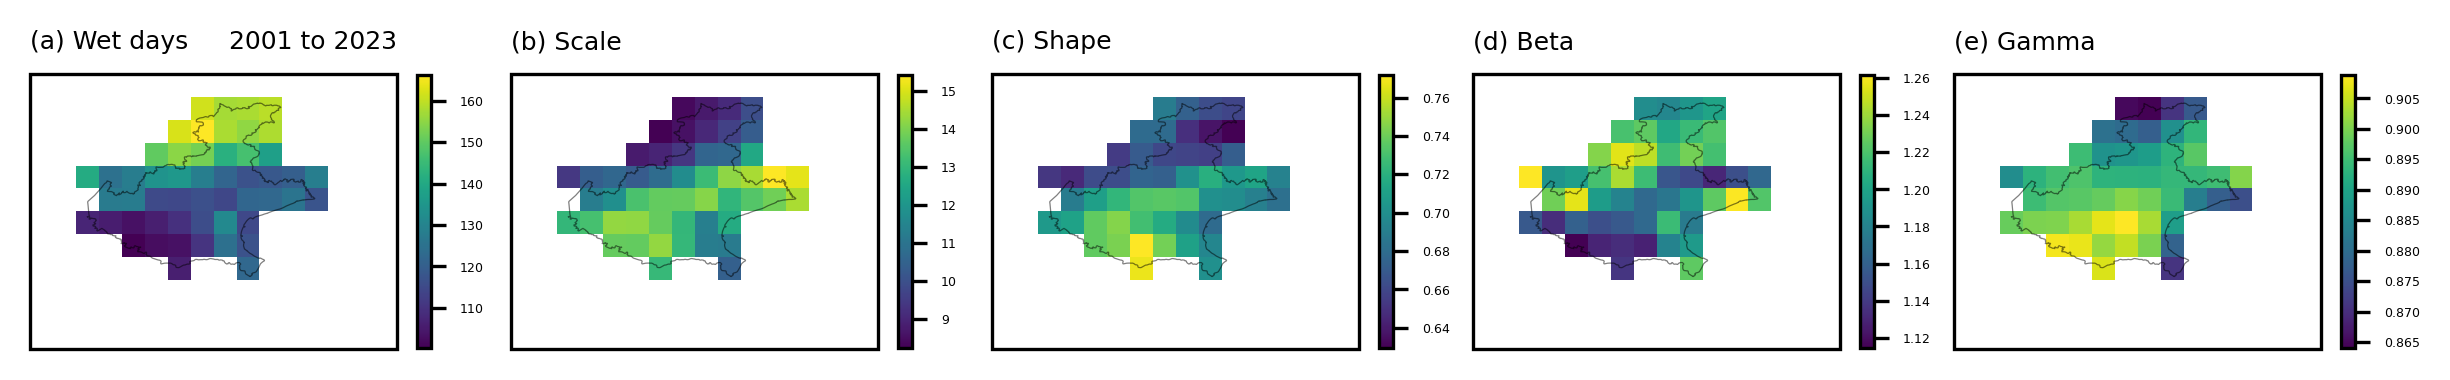

In [16]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(10,2),dpi=300)
gs = gridspec.GridSpec(1,5)

# ================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
# ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(WEIBULL_xr['DOWN_WD'],axis=0))
cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=3)
ax1.set_title('(a) Wet days', loc='left', fontsize=6)
ax1.set_title(f'{year_vector[0]} to {year_vector[-1]}', loc='right', fontsize=6)

# ================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
# ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(WEIBULL_xr['DOWN_SC'],axis=0))
cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=3)
ax1.set_title('(b) Scale', loc='left', fontsize=6)

# ================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
# ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(WEIBULL_xr['DOWN_SH'],axis=0))
cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=3)
ax1.set_title('(c) Shape', loc='left', fontsize=6)

# ================================================================
ax1 = plt.subplot(gs[0, 3], projection = proj)
# ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, WEIBULL_xr['BETA'])
cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=3)
ax1.set_title('(d) Beta', loc='left', fontsize=6)

# ================================================================
ax1 = plt.subplot(gs[0, 4], projection = proj)
# ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, WEIBULL_xr['GAMMA'])
cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=3)
ax1.set_title('(e) Gamma', loc='left', fontsize=6)